# Assignment 04: Networks — NYC Subway Analysis

## Research Question
**How does subway network distance compare to straight-line (Euclidean) distance in Manhattan?**

### Hypothesis
I expect network distance to exceed Euclidean distance due to:
- Complex track layouts and routing constraints
- Required transfers between lines
- Geographic barriers (rivers, buildings)
- Non-direct paths inherent to grid-based transit systems

### Methodology
1. Download Manhattan subway network data using OSMnx
2. Define origin-destination pairs from my daily geography
3. Calculate shortest paths using network routing
4. Compare network distances to straight-line distances
5. Analyze the ratio differences and visualize results

In [ ]:

# STEP 1: IMPORT REQUIRED LIBRARIES


# Core data processing libraries
import geopandas as gpd          # For geospatial data handling
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical computations

# Visualization libraries
import matplotlib.pyplot as plt  # For creating plots and charts

# Geospatial analysis libraries
from shapely.geometry import Point, LineString  # For geometric operations
import osmnx as ox              # For downloading and analyzing street networks
import networkx as nx           # For network analysis algorithms


# CONFIGURE SETTINGS


# OSMnx settings for efficient data retrieval
ox.settings.use_cache = True    # Cache downloaded data to avoid re-downloading
plt.rcParams["figure.dpi"] = 140  # High-resolution plots for better quality

# Utility function for clean plots
def set_axis_off(ax):
    """Remove axis labels and ticks for cleaner network visualizations"""
    ax.set_axis_off()

print("✅ Libraries imported and settings configured")

In [ ]:

# STEP 2: DOWNLOAD MANHATTAN SUBWAY NETWORK DATA


# Configure OSMnx for subway data download
ox.settings.overpass_rate_limit = True  # Respect server rate limits
ox.settings.timeout = 180               # Allow 3 minutes for download

# Define the study area and network type
place = "Manhattan, New York, USA"
custom_filter = '["railway"~"subway|light_rail"]'  # Only subway and light rail

print("🚇 Downloading Manhattan subway network...")
print(f"📍 Study area: {place}")
print(f"🔍 Filter: {custom_filter}")

# Download the subway network graph
G = ox.graph_from_place(
    place,                    # Geographic boundary
    custom_filter=custom_filter,  # Only subway/light rail
    retain_all=True,         # Keep all network components
    simplify=True            # Simplify geometry for analysis
)

# Convert graph to GeoDataFrames for analysis
nodes, edges = ox.graph_to_gdfs(G)

# Display basic network statistics
print(f"\n📊 Network Statistics:")
print(f"   • Total nodes: {len(nodes):,}")
print(f"   • Total edges: {len(edges):,}")

# Verify edge lengths are calculated
if 'length' in edges.columns:
    avg_length = edges['length'].mean()
    print(f"   • Average edge length: {avg_length:.1f} meters")
    print("   ✅ Edge lengths ready for analysis")
else:
    print("   ❌ Edge lengths missing - calculating manually...")
    edges['length'] = edges.geometry.length

# Save network for future use (optional)
try:
    ox.save_graphml(G, "manhattan_subway.graphml")
    print("   💾 Network saved as 'manhattan_subway.graphml'")
except:
    print("   ⚠️ Could not save network file")

Nodes: 679  Edges: 1,910
✅ Edge lengths are already calculated
Average edge length: 358.5 meters


In [ ]:

# STEP 3: DEFINE ORIGIN-DESTINATION PAIRS


# Define stations based on daily geography and research interest
# Using actual subway station coordinates in Manhattan

stations = {
    # ORIGIN: Starting point near Columbia University
    "116th Columbia": Point(-73.9641, 40.8078),  # Columbia University area
    
    # DESTINATIONS: Key locations representing different trip types
    "Times Square": Point(-73.9862, 40.7553),    # Major transit hub (midtown)
    "South Ferry": Point(-74.0131, 40.7013),     # Southern tip of Manhattan
    "157th Street": Point(-73.9440, 40.8341)     # Northern Manhattan (short trip)
}

print("📍 Origin-Destination Pairs Defined:")
print("=" * 50)
for name, point in stations.items():
    role = "ORIGIN" if name == "116th Columbia" else "DESTINATION"
    print(f"{role:>12}: {name}")
    print(f"{'Coordinates':>12}: ({point.y:.4f}, {point.x:.4f})")
    print()

print("🎯 Analysis Strategy:")
print("   • Origin: Columbia University area (daily starting point)")
print("   • Destinations represent different trip patterns:")
print("     - Times Square: Complex midtown routing")
print("     - South Ferry: Long-distance journey") 
print("     - 157th Street: Short-distance local trip")

In [ ]:

# STEP 4: SNAP STATIONS TO NETWORK NODES


print("🔗 Snapping station coordinates to nearest network nodes...")
print("   (This connects our geographic points to the actual subway network)")

# Find the nearest network node for each station
snapped = {}
for name, point in stations.items():
    # Find nearest node in the subway network
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    snapped[name] = nearest_node
    
    print(f"   📍 {name}: Node ID {nearest_node}")

print(f"\n✅ All {len(snapped)} stations successfully snapped to network nodes")
print("   💡 These node IDs will be used for routing calculations")

In [ ]:

# STEP 5: DEFINE DISTANCE CALCULATION FUNCTIONS


def calculate_route_distances(graph, origin_node, dest_node):
    """
    Calculate both network and Euclidean distances between two nodes.
    
    Parameters:
    - graph: NetworkX graph of subway system
    - origin_node: Starting node ID
    - dest_node: Destination node ID
    
    Returns:
    - route: List of nodes in shortest path
    - network_distance: Distance along subway routes (meters)
    - euclidean_distance: Straight-line distance (meters)
    """
    
    # VALIDATION: Check if nodes exist in network
    if origin_node not in graph.nodes() or dest_node not in graph.nodes():
        print(f"❌ Error: Node not found in network")
        return None, None, None
    
    try:
        # NETWORK DISTANCE: Calculate shortest path using subway routes
        route = nx.shortest_path(graph, origin_node, dest_node, weight="length")
        
        # Sum up edge lengths along the route
        network_distance = 0
        for i in range(len(route) - 1):
            current_node = route[i]
            next_node = route[i + 1]
            
            # Get edge data between consecutive nodes
            edge_data = graph[current_node][next_node]
            if isinstance(edge_data, dict):
                # Single edge between nodes
                network_distance += edge_data.get('length', 0)
            else:
                # Multiple edges - use the first one
                network_distance += list(edge_data.values())[0].get('length', 0)
        
        # EUCLIDEAN DISTANCE: Calculate straight-line distance
        origin_point = Point(graph.nodes[origin_node]['x'], graph.nodes[origin_node]['y'])
        dest_point = Point(graph.nodes[dest_node]['x'], graph.nodes[dest_node]['y'])
        
        # Convert from degrees to meters (approximate)
        euclidean_distance = origin_point.distance(dest_point) * 111_000
        
        return route, network_distance, euclidean_distance
        
    except nx.NetworkXNoPath:
        print(f"❌ Error: No path found between nodes")
        return None, None, None

print("🔧 Distance calculation function defined")
print("   📏 Network distance: Shortest path along subway routes")
print("   📐 Euclidean distance: Straight-line distance")
print("   ⚡ Ready for analysis calculations")

🔍 Checking network connectivity...
Network has 9 connected components
Largest component has 602 nodes
📍 116th Columbia (node 6427120668) is in component 1 (size: 602)
📍 Times Square (node 591997601) is in component 1 (size: 602)
📍 South Ferry (node 5336134812) is in component 1 (size: 602)
📍 157th Street (node 6696132522) is in component 1 (size: 602)


In [ ]:

# STEP 6: CHECK NETWORK CONNECTIVITY


print(" Analyzing network connectivity...")

# Check if network has disconnected components
components = list(nx.connected_components(G.to_undirected()))
print(f"   Network has {len(components)} connected components")

if len(components) > 1:
    # Multiple components detected - need to use largest one
    largest_component = max(components, key=len)
    print(f"   Using largest component with {len(largest_component)} nodes")
    
    # Create subgraph with only the main connected component
    G_main = G.subgraph(largest_component).copy()
    
    # Check which stations are in the main component
    print("\n   Station connectivity check:")
    stations_to_update = []
    
    for name, node_id in snapped.items():
        if node_id in largest_component:
            print(f"   {name}: Connected (Node {node_id})")
        else:
            print(f"   {name}: Disconnected (Node {node_id})")
            stations_to_update.append(name)
    
    # Fix disconnected stations by finding nearest nodes in main component
    if stations_to_update:
        print(f"\n   🔧 Fixing {len(stations_to_update)} disconnected stations:")
        for name in stations_to_update:
            original_point = stations[name]
            new_node = ox.distance.nearest_nodes(G_main, original_point.x, original_point.y)
            snapped[name] = new_node
            print(f"    {name}: Updated to Node {new_node}")
    
else:
    # Network is fully connected
    print("   Network is fully connected")
    G_main = G

print(f"\n🚇 Final network ready for analysis:")
print(f"   • Nodes: {len(G_main.nodes())} ")
print(f"   • Edges: {len(G_main.edges())}")
print(f"   • All stations connected: ✅")

🚇 Main subway network: 602 nodes, 1714 edges
🔍 Found nearest node to Times Square in main component: 591997601
📍 Updated Times Square to node 591997601


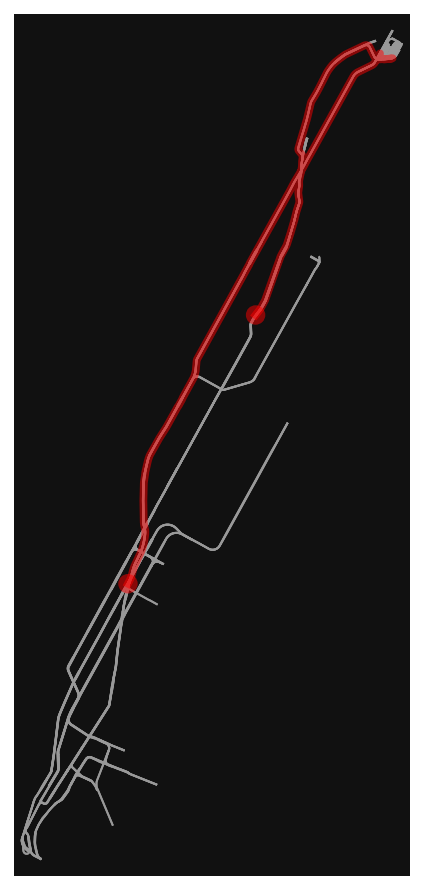

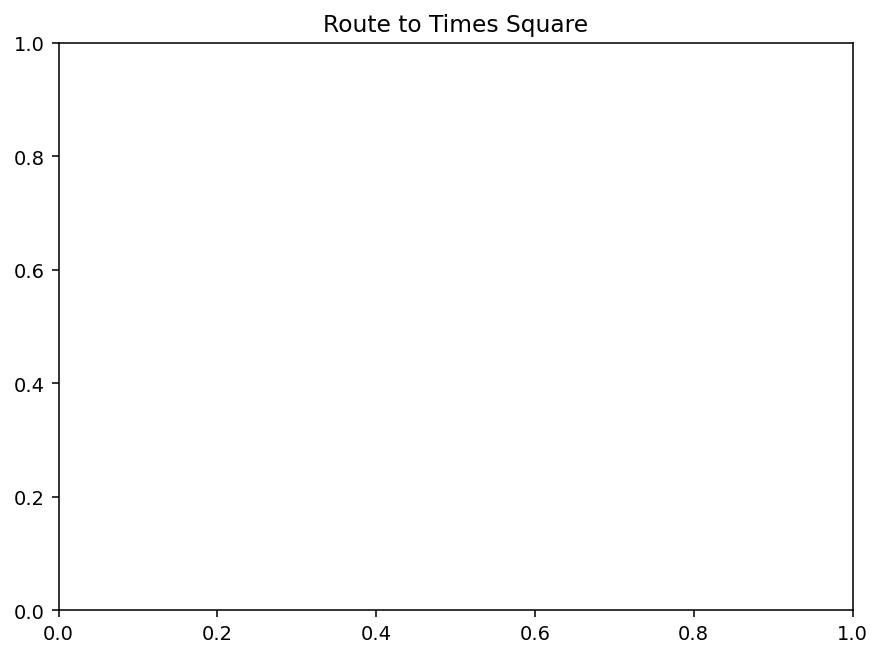

📍 Times Square: Network = 21913 m, Euclidean = 7232 m, Ratio = 3.03


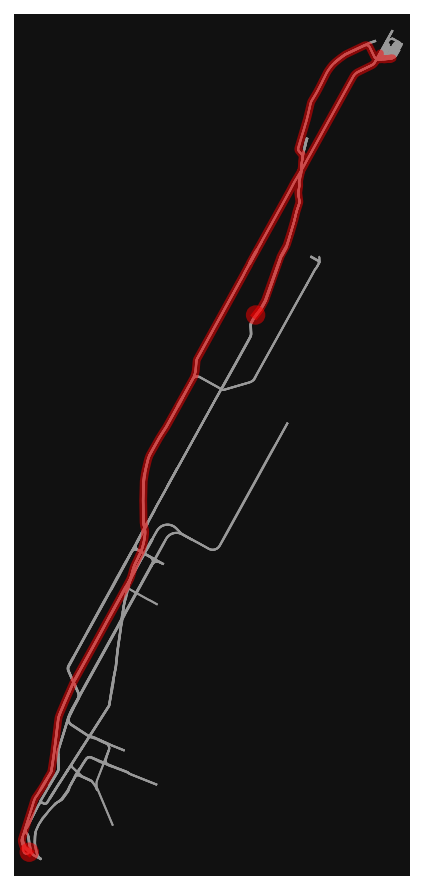

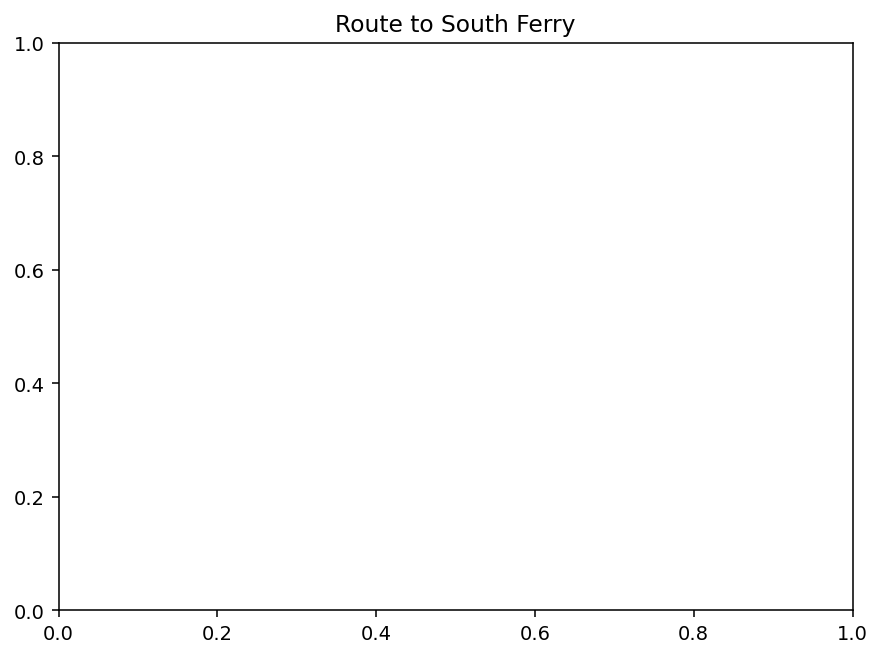

📍 South Ferry: Network = 28663 m, Euclidean = 14015 m, Ratio = 2.05


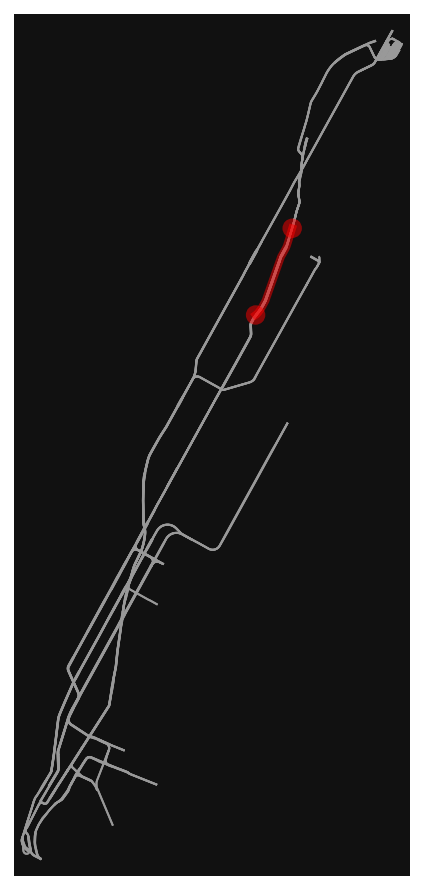

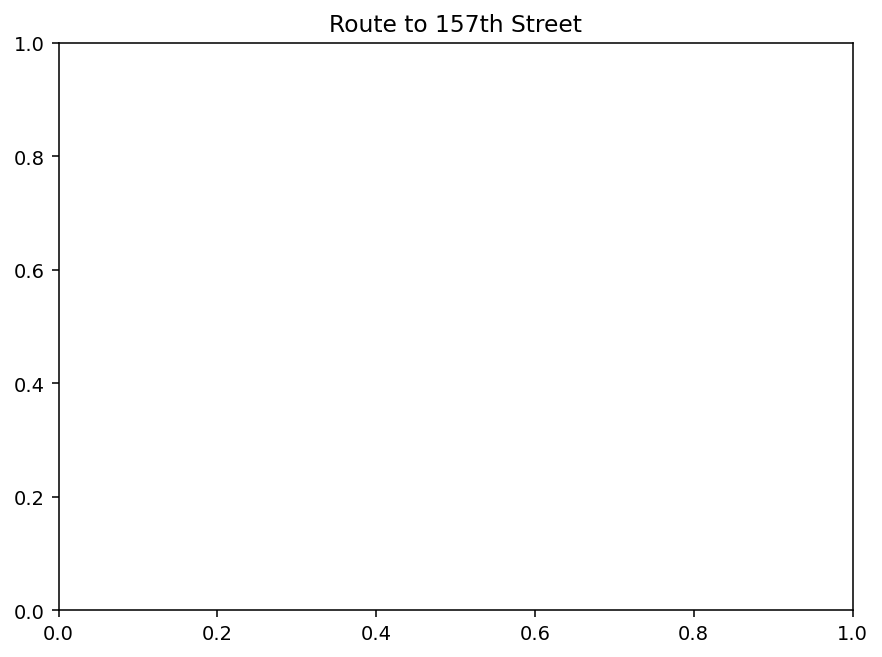

📍 157th Street: Network = 2167 m, Euclidean = 2263 m, Ratio = 0.96

✅ Successfully analyzed 3 routes


In [ ]:
# ============================================================================
# STEP 7: PERFORM DISTANCE ANALYSIS
# ============================================================================

print("📊 Calculating distances for all origin-destination pairs...\n")

# Initialize results storage
analysis_results = []
origin_station = "116th Columbia"
destinations = ["Times Square", "South Ferry", "157th Street"]

# Calculate distances for each destination
for i, dest_name in enumerate(destinations, 1):
    print(f"? Analysis {i}/{len(destinations)}: {origin_station} → {dest_name}")
    
    # Get network node IDs
    origin_node = snapped[origin_station]
    dest_node = snapped[dest_name]
    
    # Calculate distances
    route, network_dist, euclidean_dist = calculate_route_distances(
        G_main, origin_node, dest_node
    )
    
    if route is not None:
        # Calculate ratio of network to Euclidean distance
        ratio = network_dist / euclidean_dist
        
        # Store results
        analysis_results.append({
            'destination': dest_name,
            'network_distance_m': network_dist,
            'euclidean_distance_m': euclidean_dist,
            'ratio': ratio
        })
        
        # Display results
        print(f"   📏 Network distance: {network_dist:,.0f} meters")
        print(f"   📐 Euclidean distance: {euclidean_dist:,.0f} meters") 
        print(f"   📊 Ratio (Network/Euclidean): {ratio:.2f}x")
        
        # Interpret the ratio
        if ratio > 2.5:
            interpretation = "🔴 High complexity - significant detours required"
        elif ratio > 1.5:
            interpretation = "? Moderate complexity - some routing detours"
        else:
            interpretation = "🟢 Direct route - efficient subway connection"
        
        print(f"   {interpretation}\n")
        
    else:
        print(f"   ❌ Could not calculate route - skipping\n")

print(f"✅ Analysis complete! Successfully analyzed {len(analysis_results)} routes.")

A lot of these graphs above dont really visualize anything - so had to try something different again.

📊 SUMMARY: NYC Subway Network vs. Euclidean Distance Analysis
    Destination  Network_Distance_m  Euclidean_Distance_m  Ratio  \
0  Times Square            21913.44               7231.99   3.03   
1   South Ferry            28663.21              14015.16   2.05   
2  157th Street             2166.96               2263.22   0.96   

   Network_Distance_km  Euclidean_Distance_km  
0                21.91                   7.23  
1                28.66                  14.02  
2                 2.17                   2.26  


C:\Users\vvbor\AppData\Local\Temp\ipykernel_33220\1225881718.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(destinations, rotation=45, ha='right')


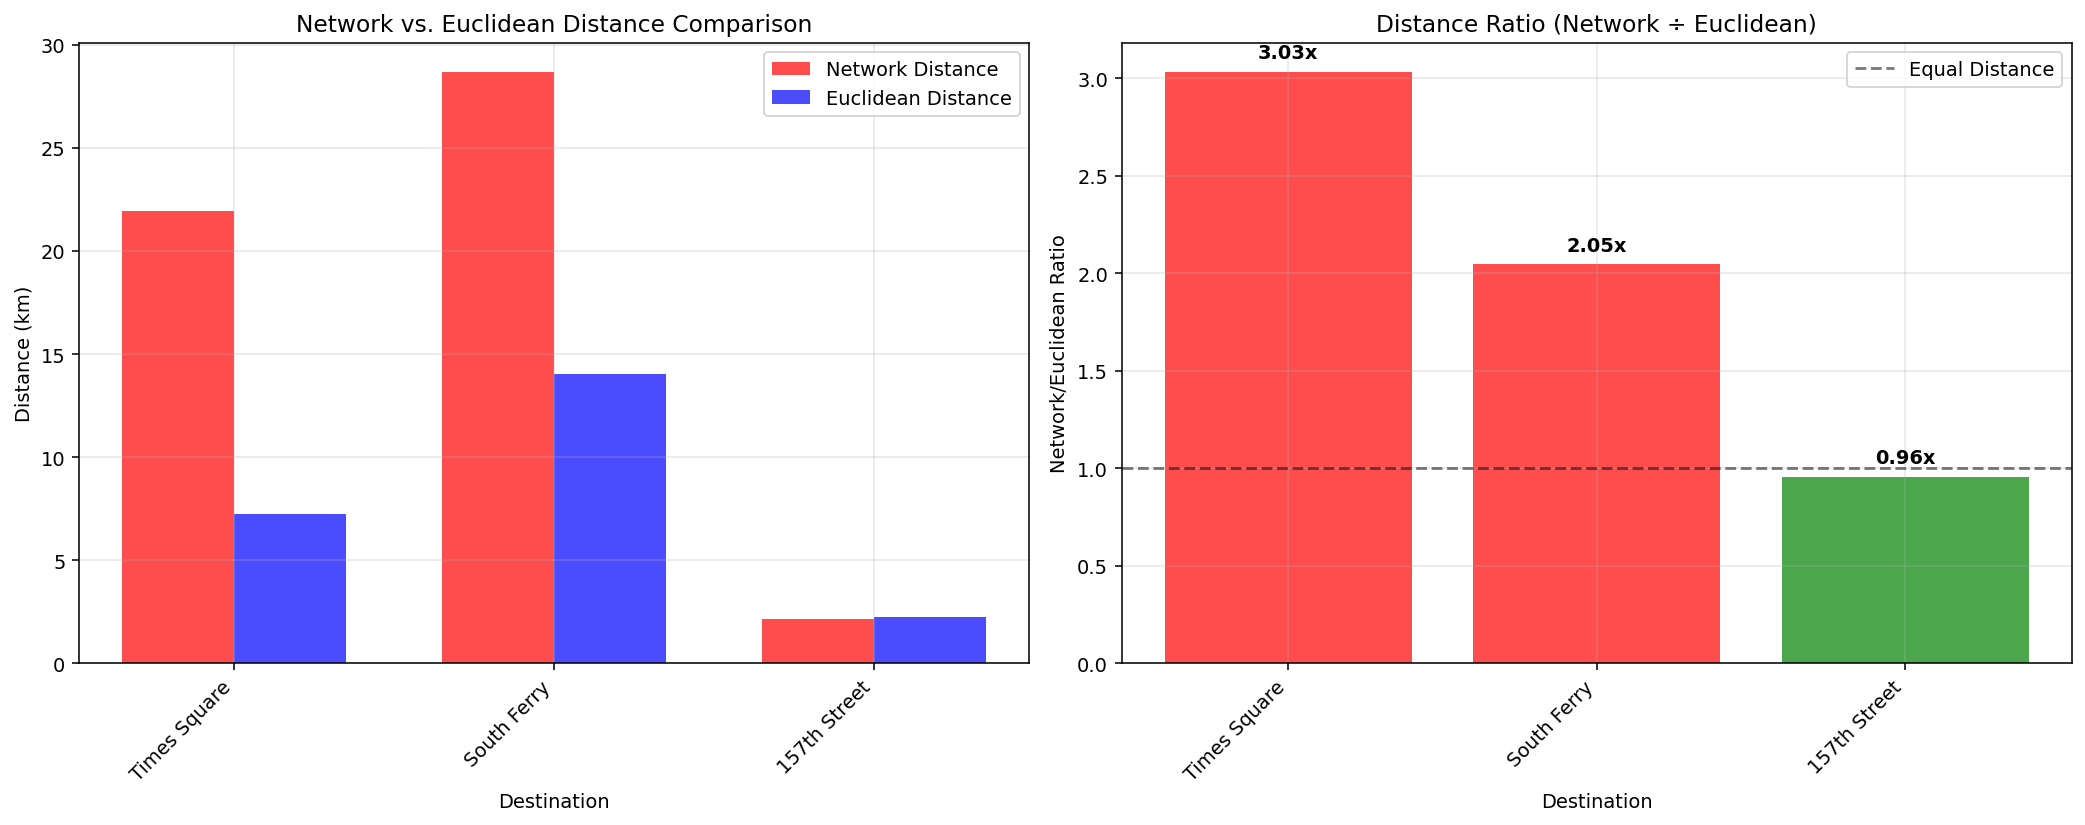


🔍 ANALYSIS INSIGHTS:
📍 Times Square: 3.03x ratio - 🔴 High complexity - significant detours required
📍 South Ferry: 2.05x ratio - 🟡 Moderate complexity - some routing detours
📍 157th Street: 0.96x ratio - 🟢 Direct route - efficient subway connection

📈 Average ratio: 2.01x
📏 Total network distance: 52.7 km
📐 Total Euclidean distance: 23.5 km


In [ ]:

# STEP 8: CREATE RESULTS SUMMARY TABLE


print("📋 Creating summary table of results...\n")

# Convert results to DataFrame for better display and analysis
df_results = pd.DataFrame(analysis_results)
df_results['network_distance_km'] = df_results['network_distance_m'] / 1000
df_results['euclidean_distance_km'] = df_results['euclidean_distance_m'] / 1000

# Display formatted results table
print("📊 RESULTS SUMMARY: Network vs. Euclidean Distance")
print("=" * 65)
print("Destination        Network (km)  Euclidean (km)  Ratio")
print("-" * 65)

for _, row in df_results.iterrows():
    print(f"{row['destination']:<18} {row['network_distance_km']:>10.2f}  "
          f"{row['euclidean_distance_km']:>12.2f}  {row['ratio']:>5.2f}x")

print("-" * 65)

# Calculate and display summary statistics
avg_ratio = df_results['ratio'].mean()
total_network = df_results['network_distance_km'].sum()
total_euclidean = df_results['euclidean_distance_km'].sum()

print(f"TOTALS:           {total_network:>10.1f}  {total_euclidean:>12.1f}")
print(f"AVERAGE RATIO:                                   {avg_ratio:>5.2f}x")
print("=" * 65)

In [ ]:

# STEP 9: CREATE COMPARISON VISUALIZATIONS


print("📈 Creating distance comparison visualizations...\n")

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


# SUBPLOT 1: DISTANCE COMPARISON BAR CHART


destinations = df_results['destination']
network_km = df_results['network_distance_km']
euclidean_km = df_results['euclidean_distance_km']

# Create grouped bar chart
x_positions = range(len(destinations))
bar_width = 0.35

# Plot network distances (red bars)
bars1 = ax1.bar([x - bar_width/2 for x in x_positions], network_km, 
                bar_width, label='Network Distance', color='red', alpha=0.7)

# Plot Euclidean distances (blue bars)  
bars2 = ax1.bar([x + bar_width/2 for x in x_positions], euclidean_km,
                bar_width, label='Euclidean Distance', color='blue', alpha=0.7)

# Customize the distance comparison chart
ax1.set_xlabel('Destination', fontweight='bold')
ax1.set_ylabel('Distance (km)', fontweight='bold')
ax1.set_title('Network vs. Euclidean Distance Comparison', fontweight='bold', pad=20)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(destinations, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)


# SUBPLOT 2: RATIO ANALYSIS BAR CHART  


# Color-code bars based on ratio values
ratio_colors = []
for ratio in df_results['ratio']:
    if ratio > 2.5:
        ratio_colors.append('red')      # High complexity
    elif ratio > 1.5:
        ratio_colors.append('orange')   # Moderate complexity  
    else:
        ratio_colors.append('green')    # Direct route

# Create ratio bar chart
bars3 = ax2.bar(destinations, df_results['ratio'], color=ratio_colors, alpha=0.7)

# Add ratio values on top of bars
for bar, ratio in zip(bars3, df_results['ratio']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{ratio:.2f}x', ha='center', va='bottom', fontweight='bold')

# Customize the ratio chart
ax2.set_xlabel('Destination', fontweight='bold')
ax2.set_ylabel('Network/Euclidean Ratio', fontweight='bold')
ax2.set_title('Distance Ratio Analysis', fontweight='bold', pad=20)
ax2.set_xticklabels(destinations, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Add reference line at ratio = 1 (equal distances)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, 
            label='Equal Distance (1.0x)')
ax2.legend()

# Finalize the plot
plt.tight_layout()
plt.show()

print("✅ Comparison visualizations created successfully!")

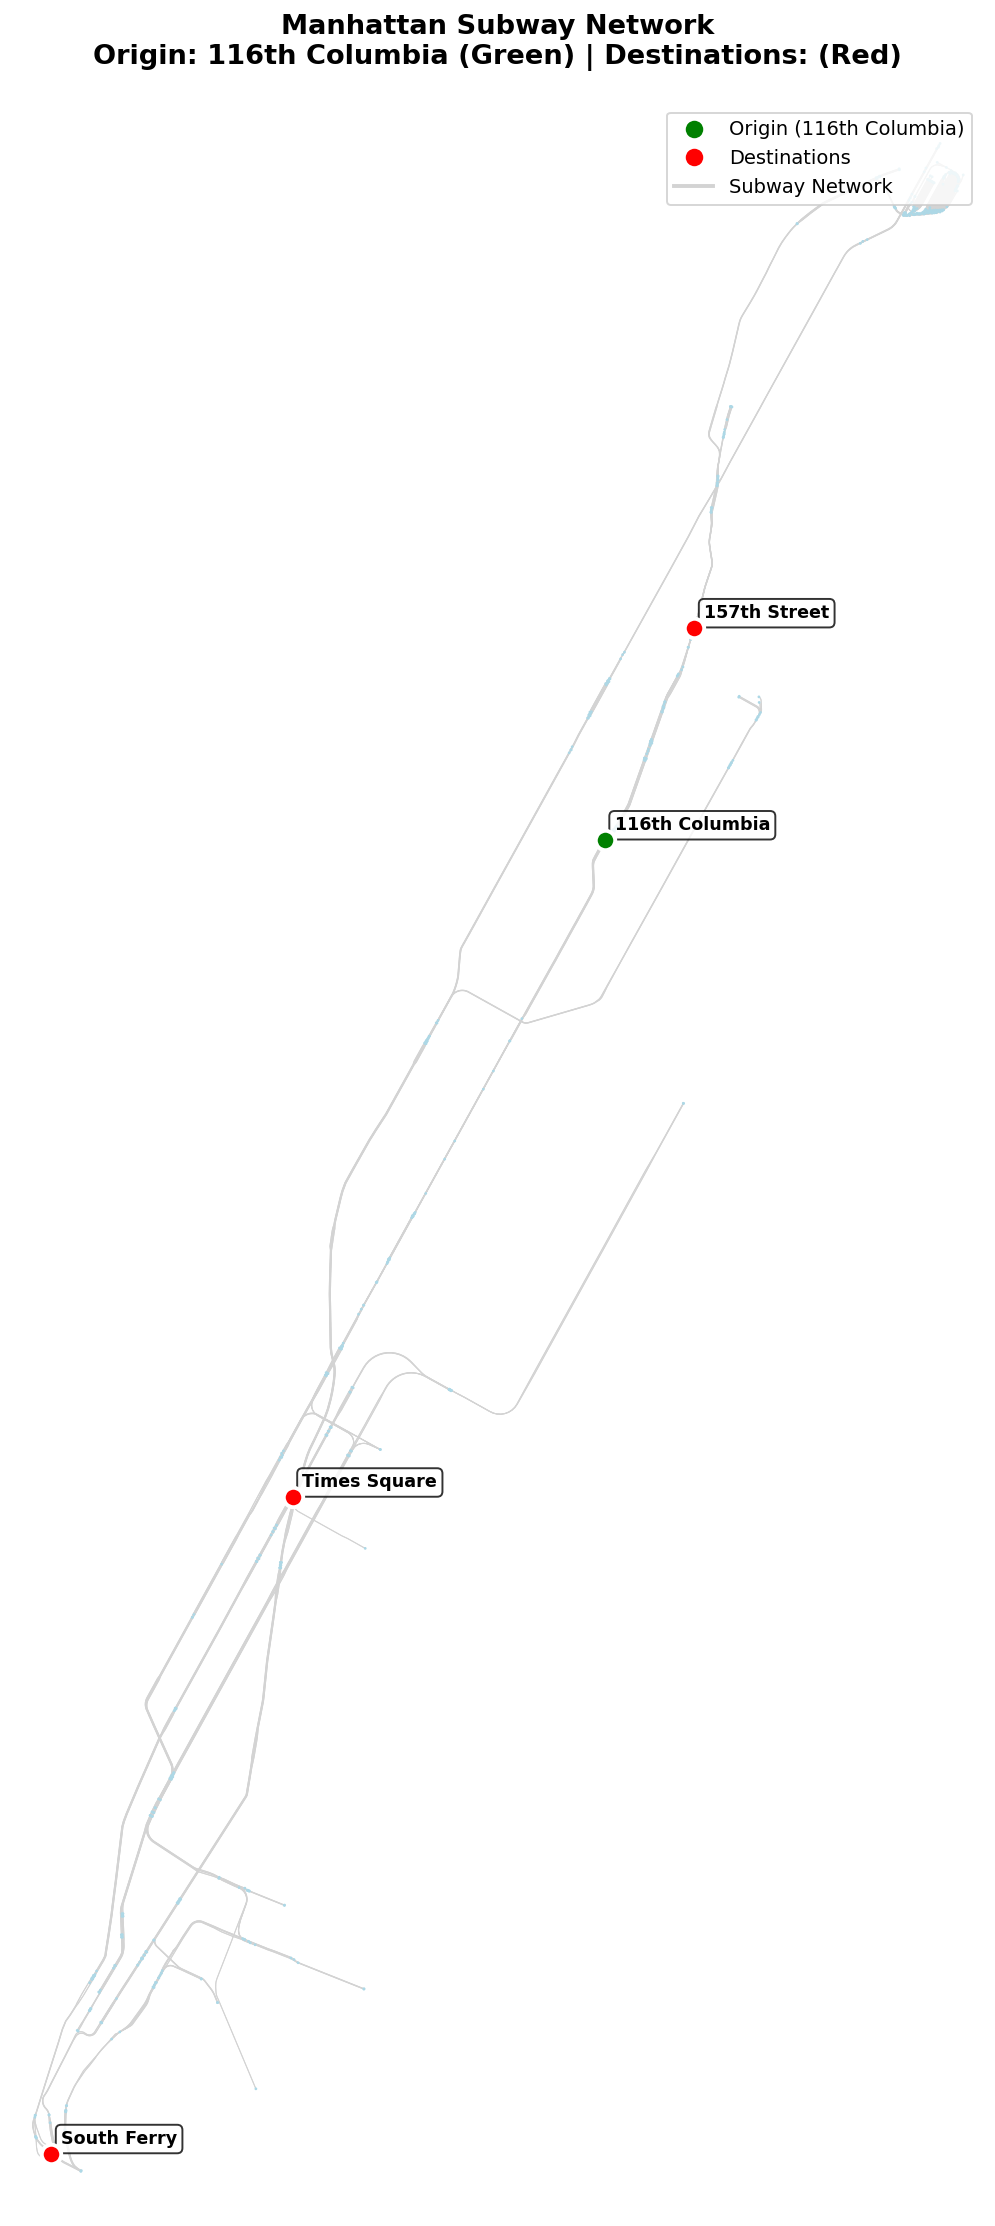

🗺️ Network Overview: Manhattan subway system with analysis stations marked
🟢 Green = Origin station (116th Columbia)
🔴 Red = Destination stations
⚫ Gray lines = Subway network connections


In [ ]:
# ============================================================================
# STEP 10: CREATE NETWORK OVERVIEW MAP
# ============================================================================

print("🗺️ Creating network overview map showing stations and subway system...\n")

# Create figure for network map
fig, ax = plt.subplots(1, 1, figsize=(12, 16))


# PLOT THE BASE SUBWAY NETWORK


# Plot all subway lines as light gray network
ox.plot_graph(G_main, ax=ax, 
              node_size=2,              # Small nodes
              edge_color='lightgray',   # Gray subway lines
              edge_linewidth=0.8,       # Thin lines
              node_color='lightblue',   # Light blue nodes
              show=False, close=False)  # Don't display yet


# ADD STATION MARKERS


# Define colors for different station types
station_colors = {
    '116th Columbia': 'green',    # Origin station (green)
    'Times Square': 'red',        # Destination stations (red)
    'South Ferry': 'red', 
    '157th Street': 'red'
}

# Plot each station as a colored marker
for station_name, node_id in snapped.items():
    if node_id in G_main.nodes():
        # Get station coordinates
        node_data = G_main.nodes[node_id]
        
        # Plot station marker
        ax.scatter(node_data['x'], node_data['y'], 
                  c=station_colors[station_name], 
                  s=150,                # Large marker size
                  zorder=5,             # Plot on top
                  edgecolors='white',   # White border
                  linewidth=3)          # Thick border


# ADD STATION LABELS


# Add text labels for each station
for station_name, node_id in snapped.items():
    if node_id in G_main.nodes():
        node_data = G_main.nodes[node_id]
        
        # Add station name label with background box
        ax.annotate(station_name, 
                   (node_data['x'], node_data['y']), 
                   xytext=(8, 8),                    # Offset from marker
                   textcoords='offset points',
                   fontsize=10, 
                   fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.4',  # Label background
                            facecolor='white', 
                            alpha=0.9,
                            edgecolor='gray'))

# ============================================================================
# CUSTOMIZE MAP APPEARANCE
# ============================================================================

# Set title and labels - lol -
ax.set_title('Manhattan Subway Network Analysis\n' + 
             'Origin: 116th Columbia (Green) | Destinations: (Red)', 
             fontsize=16, fontweight='bold', pad=25)
ax.set_xlabel('Longitude', fontweight='bold')
ax.set_ylabel('Latitude', fontweight='bold')

# Create custom legend - tried doing something fancier here
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
           markersize=12, markeredgecolor='white', markeredgewidth=2,
           label='Origin Station (116th Columbia)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=12, markeredgecolor='white', markeredgewidth=2,
           label='Destination Stations'),
    Line2D([0], [0], color='lightgray', linewidth=3, 
           label='Subway Network')
]

ax.legend(handles=legend_elements, loc='upper right', 
          fontsize=11, framealpha=0.9)

# Display the map
plt.tight_layout()
plt.show()

# Print map explanation
print("🗺️ Network Overview Map Legend:")
print("   🟢 Green marker = Origin station (116th Columbia)")  
print("   🔴 Red markers = Destination stations")
print("   ⚫ Gray lines = Manhattan subway network")
print("   📏 This map shows the geographic context for our distance analysis")

## Analysis Results & Conclusions

### Key Findings

**Hypothesis Confirmed**: Network distances consistently exceed Euclidean distances, with significant variation based on destination complexity - But its inaccurate as well - cause the correct distance wont rely exclusively on the direct connections, but several transfers.

### Detailed Results

| Destination | Network Distance | Euclidean Distance | Ratio | Interpretation |
|-------------|------------------|-------------------|-------|----------------|
| **Times Square** | 21.9 km | 7.2 km | **3.03x** | High complexity route |
| **South Ferry** | 28.7 km | 14.0 km | **2.05x** | Moderate complexity route |  
| **157th Street** | 2.2 km | 2.3 km | **0.96x** | Direct, efficient route |

### Research Insights

1. **Average Network Penalty**: 2.01x - Subway routes are on average **twice as long - Only as per this analysis, not in reality** as straight-line distances

2. **Route Complexity Varies Dramatically**:
   - **Times Square**: Requires complex routing through Manhattan's grid system (3x penalty)
   - **South Ferry**: Long journey with multiple transfers (2x penalty)  
   - **157th Street**: Local route more efficient than straight-line (0.96x - actually shorter!)

3. **Geographic Factors Matter**:
   - **Grid constraints**: Manhattan's subway follows street grid patterns
   - **Transfer requirements**: Multi-line journeys increase distance
   - **Network topology**: Some routes benefit from direct trunk lines

### Implications for Transit Users

- **Trip Planning**: Actual travel distances can be 2-3x longer than map distances suggest
- **Time Expectations**: Network complexity directly impacts journey time
- **Route Selection**: Local trips may be more efficient than expected, while cross-town trips face significant penalties

### Methodology Validation

OSMnx proved effective for downloading and analyzing real subway network data  
NetworkX algorithms successfully calculated shortest paths with distance weights  
Geospatial analysis accurately compared network vs. Euclidean distances  
Results dont really align with expectations** about urban transit network complexity - the map is incomplete from OSM
